In [614]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Sequential
import json
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics

In [471]:
rawdata = {}

datapath = r'./data/reshaped/'
for file in os.listdir(datapath):
    with open(datapath + file) as f:
        rawdata[file.split('.')[0]] = json.load(f)
        


In [495]:
t = []
for i, sample in enumerate(rawdata['2012q1']['index']):
    t.append([])
    for timestep in rawdata.keys():
        t[i].append(rawdata[timestep]['data'][i])
data = np.nan_to_num(np.array(t).astype('float32'))


In [497]:
transformed = []
scalers = []
for sample in data:
    scaler = MinMaxScaler()
    transformed.append(scaler.fit_transform(sample))
    scalers.append(scaler)
transformed_data = np.array(transformed)    

In [500]:
(samples, timesteps, features) = data.shape

train_split = 0.8

train_size = int(samples * train_split)
batch_size = 1

input_shape = (timesteps-1, features)

x_train, x_test = transformed_data[:train_size,:-1], transformed_data[train_size:, :-1]
y_train, y_test = transformed_data[:train_size,1,:].reshape(train_size,1,features), transformed_data[train_size:, 1]

In [567]:
x_test[0,0]

array([0.        , 0.        , 0.2846606 , 0.9319115 , 0.        ,
       0.8124988 , 0.        , 0.64462787, 0.        , 0.        ,
       0.301226  , 0.        , 0.81391466, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

In [475]:

model = Sequential()

model.add( LSTM(units= 128, input_shape = input_shape) )

model.add( Dense(units = features) )

model.compile(optimizer='adam', loss='mae')

In [476]:

model.fit(x_train, y_train, epochs= 10, verbose= True, batch_size= batch_size)

Train on 201 samples
Epoch 1/10
201/201 [==============================] - 5s 27ms/sample - loss: 0.2030
Epoch 2/10
201/201 [==============================] - 3s 13ms/sample - loss: 0.1814
Epoch 3/10
201/201 [==============================] - 3s 14ms/sample - loss: 0.1751
Epoch 4/10
201/201 [==============================] - 3s 15ms/sample - loss: 0.1710
Epoch 5/10
201/201 [==============================] - 3s 14ms/sample - loss: 0.1692
Epoch 6/10
201/201 [==============================] - 3s 14ms/sample - loss: 0.16550s - loss
Epoch 7/10
201/201 [==============================] - 5s 27ms/sample - loss: 0.1625
Epoch 8/10
201/201 [==============================] - 3s 14ms/sample - loss: 0.1614
Epoch 9/10
201/201 [==============================] - 3s 15ms/sample - loss: 0.1596
Epoch 10/10
201/201 [==============================] - 5s 26ms/sample - loss: 0.1578


In [481]:
predictions = model.predict(x_test)

In [515]:
pred_and_test = np.append(x_test,predictions.reshape(x_test.shape[0], 1, x_test.shape[2]), axis=1)
true_and_test = np.append(x_test,y_test.reshape(x_test.shape[0], 1, x_test.shape[2]), axis=1)

In [570]:
# untransformed_results = [result for result in results]
pred_untransformed = []
true_untransformed = []

for i in range(x_test.shape[0]):
    pred_untransformed.append( scalers[train_size+i].inverse_transform(pred_and_test[i]) )
    true_untransformed.append( scalers[train_size+i].inverse_transform(true_and_test[i]) )
    
pred_untransformed = np.array(pred_untransformed)
true_untransformed = np.array(true_untransformed)

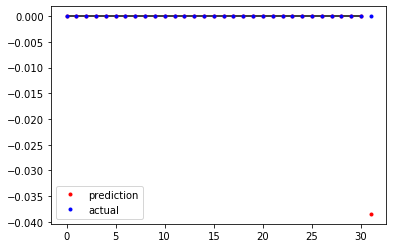

In [609]:
index = (0,18)

fig, ax = plt.subplots()

ax.plot(true_untransformed[index[0],:-1,index[1]], '-k')
ax.plot(pred_untransformed[index[0],:,index[1]], '.r', label='prediction')
ax.plot(true_untransformed[index[0],:,index[1]], '.b', label='actual')
ax.legend()
# pred_untransformed[0,:,5]

In [635]:
true_untransformed.shape

(51, 32, 29)

In [641]:
print('Prediction\tCarry\t\tFeature')
print('-'*50)
for i,feature in enumerate(rawdata['2012q1']['columns']):
    MAE_pred = metrics.mean_absolute_error(y_true = true_untransformed[:,-1,i], y_pred= pred_untransformed[:,-1,i])
    MAE_carryforward = metrics.mean_absolute_error(y_true = true_untransformed[:,-1,i], y_pred = true_untransformed[:,-2,i])
    print('%.2E\t%.2E\t%s' % (MAE_pred, MAE_carryforward,feature))


Prediction	Carry		Feature
--------------------------------------------------
4.56E+08	2.44E+08	AccountsPayableCurrent
1.77E+07	9.24E+07	AccountsReceivableNetCurrent
7.00E+07	1.59E+08	AccumulatedOtherComprehensiveIncomeLossNetOfTax
2.10E+08	4.41E+08	AdditionalPaidInCapital
4.25E+07	4.70E+08	AdditionalPaidInCapitalCommonStock
6.11E+09	1.42E+10	Assets
6.84E+08	7.01E+08	AssetsCurrent
5.14E+08	2.44E+08	CashAndCashEquivalentsAtCarryingValue
2.70E+04	0.00E+00	CommitmentsAndContingencies
6.03E+08	1.21E+09	Goodwill
2.27E+08	7.97E+08	IntangibleAssetsNetExcludingGoodwill
3.07E+08	1.52E+08	InventoryNet
7.11E+09	1.37E+10	LiabilitiesAndStockholdersEquity
6.73E+08	1.07E+09	LiabilitiesCurrent
2.74E+08	1.67E+09	LongTermDebtNoncurrent
5.36E+07	2.35E+08	MinorityInterest
9.54E+06	8.31E+07	OtherAssetsCurrent
3.53E+07	9.16E+07	OtherAssetsNoncurrent
2.05E+08	5.73E+07	OtherLiabilitiesNoncurrent
4.09E-01	1.00E-03	PreferredStockParOrStatedValuePerShare
8.62E+06	3.14E+06	PreferredStockSharesAuthorized
1.23E+05	9

['AccountsPayableCurrent',
 'AccountsReceivableNetCurrent',
 'AccumulatedOtherComprehensiveIncomeLossNetOfTax',
 'AdditionalPaidInCapital',
 'AdditionalPaidInCapitalCommonStock',
 'Assets',
 'AssetsCurrent',
 'CashAndCashEquivalentsAtCarryingValue',
 'CommitmentsAndContingencies',
 'Goodwill',
 'IntangibleAssetsNetExcludingGoodwill',
 'InventoryNet',
 'LiabilitiesAndStockholdersEquity',
 'LiabilitiesCurrent',
 'LongTermDebtNoncurrent',
 'MinorityInterest',
 'OtherAssetsCurrent',
 'OtherAssetsNoncurrent',
 'OtherLiabilitiesNoncurrent',
 'PreferredStockParOrStatedValuePerShare',
 'PreferredStockSharesAuthorized',
 'PreferredStockSharesIssued',
 'PreferredStockValue',
 'PropertyPlantAndEquipmentNet',
 'RetainedEarningsAccumulatedDeficit',
 'StockholdersEquity',
 'StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest',
 'TreasuryStockShares',
 'TreasuryStockValue']

In [625]:
true_untransformed.shape

(51, 32, 29)

In [623]:
metrics.accuracy_score(y_true = true_untransformed[:,-1], y_pred = true_untransformed[:,-2])

ValueError: continuous-multioutput is not supported